In [14]:
# ! pip install -q kaggle

In [15]:
# ! mkdir ~/.kaggle

In [ ]:
# from google.colab import files
# files.upload()

In [17]:
# !cp kaggle.json ~/.kaggle/

In [18]:
# ! kaggle datasets download -d nibinv23/iam-handwriting-word-database

Dataset URL: https://www.kaggle.com/datasets/nibinv23/iam-handwriting-word-database
License(s): unknown
 99% 1.09G/1.10G [00:15<00:00, 76.6MB/s]
100% 1.10G/1.10G [00:15<00:00, 74.7MB/s]


In [19]:
import zipfile
zip_ref = zipfile.ZipFile("/content/iam-handwriting-word-database.zip", 'r')
zip_ref.extractall("/content/drive/MyDrive/Dataset/iam-handwriting-dataset/")
zip_ref.close()

In [20]:
import numpy as np
import cv2
import pandas as pd
import string
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [28]:
with open('/content/drive/MyDrive/Dataset/iam-handwriting-dataset/iam_words/words.txt') as f:
    contents = f.readlines()

lines = [line.strip() for line in contents][18:]
lines[0]

'a01-000u-00-00 ok 154 408 768 27 51 AT A'

In [29]:
max_label_len = 0

char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

# string.ascii_letters + string.digits (Chars & Digits)
# or
# "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

print(char_list, len(char_list))

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(char_list.index(chara))

    return dig_lst

!"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz 78


In [30]:
images = []
labels = []

RECORDS_COUNT = 10000

In [31]:
train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

inputs_length = []
labels_length = []

In [32]:
def process_image(img):
    """
    Converts image to shape (32, 128, 1) & normalize
    """
    w, h = img.shape

#
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape

    img = img.astype('float32')

    # Converts each to (32, 128, 1)
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape

    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape

    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)

    img = cv2.subtract(255, img)

    img = np.expand_dims(img, axis=2)

    # Normalize
    img = img / 255

    return img

In [45]:
for index, line in enumerate(lines):
    splits = line.split(' ')
    status = splits[1]

    if status == 'ok':
        word_id = splits[0]
        word = "".join(splits[8:])

        splits_id = word_id.split('-')
        filepath = f'/content/drive/MyDrive/Dataset/iam-handwriting-dataset/iam_words/words/{splits_id[0]}/{splits_id[0]}-{splits_id[1]}/{word_id}.png'

        # processing on image
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        try:
            img = process_image(img)
        except:
            continue

        # processing on label
        try:
            label = encode_to_labels(word)
        except:
            continue

        if index % 10 == 0:
            valid_images.append(img)
            valid_labels.append(label)
            valid_input_length.append(31)
            valid_label_length.append(len(word))
            valid_original_text.append(word)
        else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(31)
            train_label_length.append(len(word))
            train_original_text.append(word)

        if len(word) > max_label_len:
            max_label_len = len(word)

    if index >= RECORDS_COUNT:
        break

In [46]:
train_padded_label = pad_sequences(train_labels,
                             maxlen=max_label_len,
                             padding='post',
                             value=len(char_list))

valid_padded_label = pad_sequences(valid_labels,
                             maxlen=max_label_len,
                             padding='post',
                             value=len(char_list))

In [47]:
train_padded_label.shape, valid_padded_label.shape

((7850, 16), (876, 16))

In [48]:
train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

In [49]:
train_images.shape

(7850, 32, 128, 1)

In [50]:
# input with shape of height=32 and width=128
inputs = Input(shape=(32,128,1))

# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)

conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)

# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)

# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)

conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)

squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)

outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)
act_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 32, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 32, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 32, 256)        295168

In [51]:
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args

    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

In [52]:
batch_size = 8
epochs = 30
e = str(epochs)
optimizer_name = 'sgd'

In [53]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer_name, metrics=['accuracy'])

In [55]:
history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=2)

Epoch 1/30
982/982 - 44s - loss: 15.6429 - accuracy: 0.0000e+00 - val_loss: 16.0172 - val_accuracy: 0.0000e+00 - 44s/epoch - 45ms/step
Epoch 2/30
982/982 - 27s - loss: 13.2081 - accuracy: 0.0099 - val_loss: 22.6654 - val_accuracy: 0.0434 - 27s/epoch - 28ms/step
Epoch 3/30
982/982 - 26s - loss: 11.6319 - accuracy: 0.0490 - val_loss: 12.1619 - val_accuracy: 0.0388 - 26s/epoch - 27ms/step
Epoch 4/30
982/982 - 26s - loss: 10.1646 - accuracy: 0.0776 - val_loss: 10.3292 - val_accuracy: 0.0879 - 26s/epoch - 26ms/step
Epoch 5/30
982/982 - 27s - loss: 8.4501 - accuracy: 0.1225 - val_loss: 8.6633 - val_accuracy: 0.1221 - 27s/epoch - 27ms/step
Epoch 6/30
982/982 - 26s - loss: 6.6180 - accuracy: 0.1687 - val_loss: 6.0425 - val_accuracy: 0.2100 - 26s/epoch - 27ms/step
Epoch 7/30
982/982 - 26s - loss: 5.2057 - accuracy: 0.2236 - val_loss: 6.7754 - val_accuracy: 0.2123 - 26s/epoch - 27ms/step
Epoch 8/30
982/982 - 27s - loss: 4.1446 - accuracy: 0.2772 - val_loss: 7.3658 - val_accuracy: 0.2329 - 27s/ep

In [56]:
history_dict = {
    'epoch': list(range(1, len(history.history['loss']) + 1)),
    'loss': history.history['loss'],
    'accuracy': history.history['accuracy'],
    'val_loss': history.history['val_loss'],
    'val_accuracy': history.history['val_accuracy']
}
history_df = pd.DataFrame(history_dict)
excel_file_path = 'training_history.xlsx'
history_df.to_excel(excel_file_path, index=False)

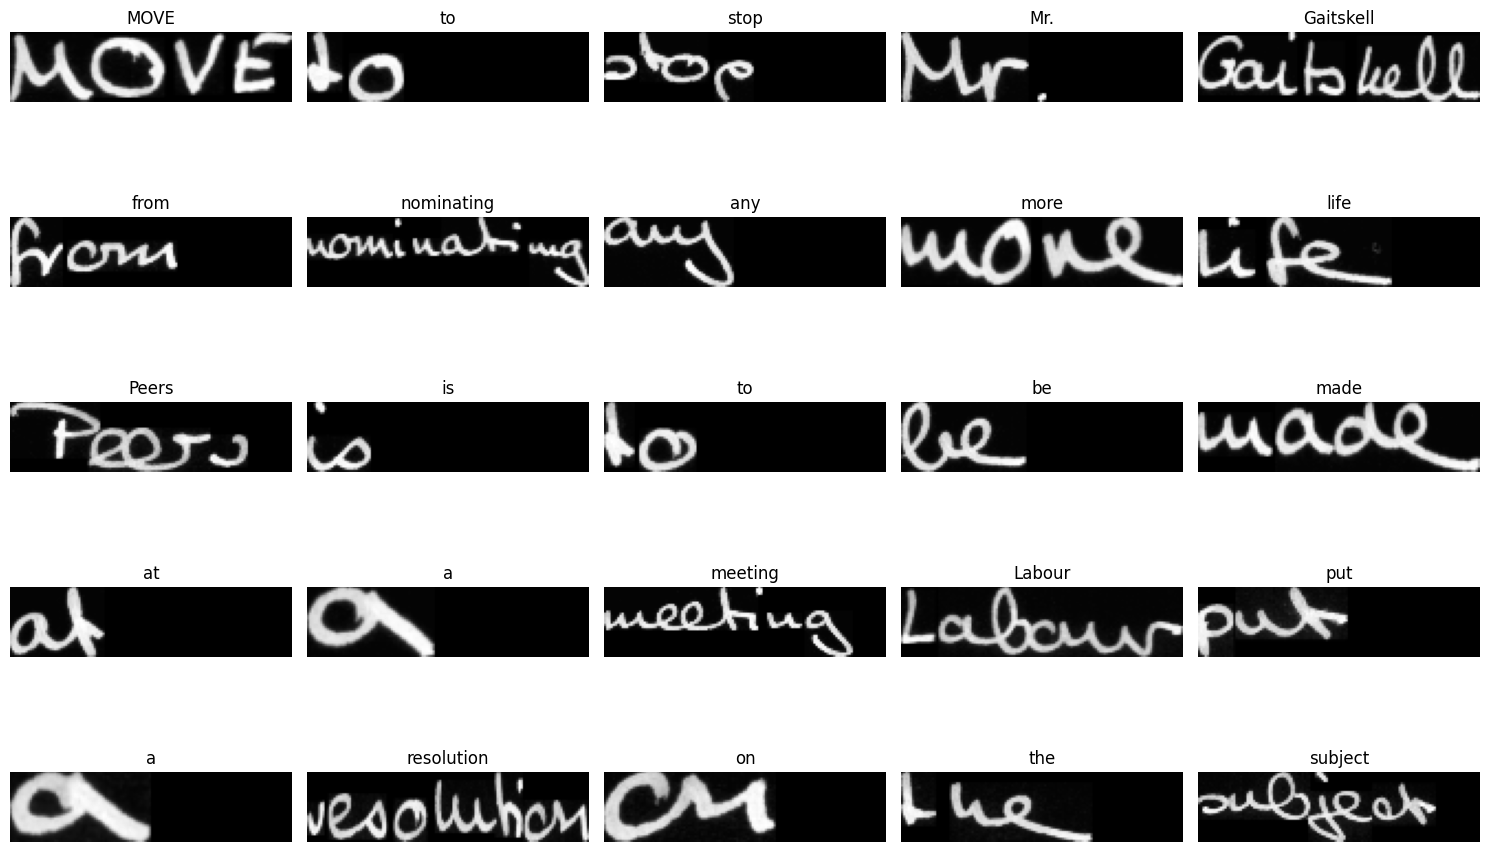

In [71]:
plt.figure(figsize=(15, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(train_images[i].squeeze(), cmap='gray')
    plt.title(train_original_text[i])
    plt.axis('off')
plt.tight_layout()
plt.show()


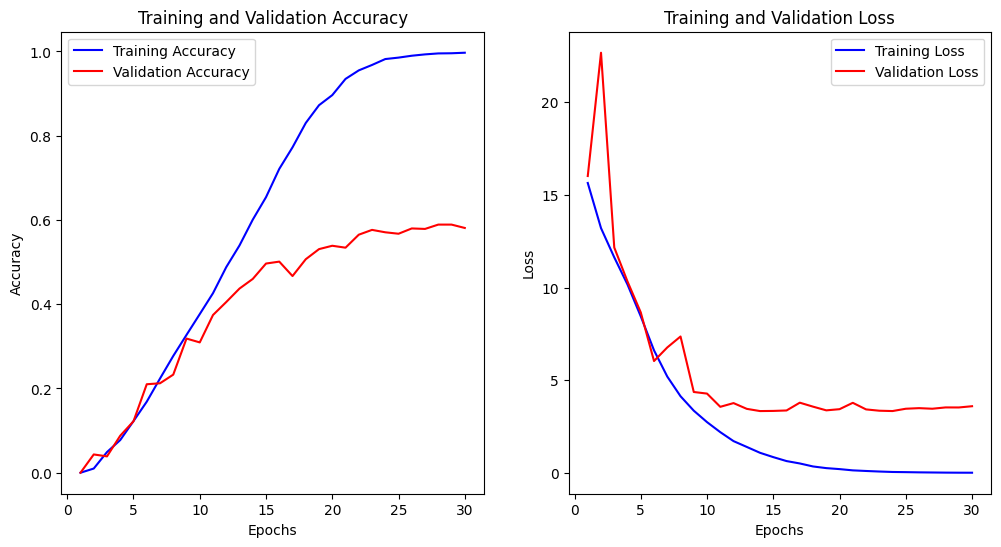

In [64]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, "b", label="Training Accuracy")
plt.plot(epochs, val_acc, "r", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "b", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [65]:
model.save('/content/drive/MyDrive/models/extractingtext_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
